In [70]:
# Machine Learning Challenge Solution
# Based on the slides: "Practicing Python for ML"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [71]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

print("Dataset loaded successfully!")
print(f"Dataset shape: {X.shape}")
print(f"Target classes: {target_names}")
print(f"Features: {feature_names}")

# Split the dataset into training and validation sets
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

print(f"\nTraining set size: {X_train.shape}")
print(f"Validation set size: {X_validation.shape}")

Dataset loaded successfully!
Dataset shape: (150, 4)
Target classes: ['setosa' 'versicolor' 'virginica']
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Training set size: (120, 4)
Validation set size: (30, 4)


In [76]:
# Initialize all algorithms
models = {
    'LR': LogisticRegression(solver='liblinear', multi_class='ovr'),
    'LDA': LinearDiscriminantAnalysis(),
    'KNN': KNeighborsClassifier(),
    'CART': DecisionTreeClassifier(),
    'NB': GaussianNB(),
    'SVM': SVC(gamma='auto')
}

# Evaluate models using 10-fold cross validation
print("\n" + "="*60)
print("MODEL EVALUATION USING 10-FOLD CROSS VALIDATION")
print("="*60)

cv_results = {}
kfold = KFold(n_splits=10, random_state=1, shuffle=True)

for name, model in models.items():
    cv_result = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    cv_results[name] = cv_result
    print(f"{name}: {cv_result.mean():.6f} ({cv_result.std():.6f})")

# Train all models and make predictions
print("\n" + "="*60)
print("TRAINING MODELS AND MAKING PREDICTIONS")
print("="*60)

predictions = {}
trained_models = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    trained_models[name] = model

    # Make predictions
    predictions[name] = model.predict(X_validation)

    # Calculate accuracy
    accuracy = accuracy_score(y_validation, predictions[name])
    print(f"{name} Accuracy: {accuracy:.6f}")



MODEL EVALUATION USING 10-FOLD CROSS VALIDATION
LR: 0.933333 (0.089753)
LDA: 0.975000 (0.038188)
KNN: 0.958333 (0.041667)
CART: 0.958333 (0.041667)
NB: 0.950000 (0.040825)
SVM: 0.983333 (0.033333)

TRAINING MODELS AND MAKING PREDICTIONS
LR Accuracy: 0.833333
LDA Accuracy: 1.000000
KNN Accuracy: 1.000000
CART Accuracy: 0.966667
NB Accuracy: 0.966667
SVM Accuracy: 0.966667


In [77]:
# Function to calculate metrics for multiclass classification
def calculate_multiclass_metrics(y_true, y_pred, target_names):
    """Calculate precision, recall, and F1-score for each class and overall"""

    # Overall metrics (macro average)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)

    # Per-class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class
    }

# Function to manually calculate TP, TN, FP, FN for each class
def calculate_confusion_metrics(y_true, y_pred, num_classes):
    """Manually calculate TP, TN, FP, FN for each class"""
    metrics = {}

    for class_idx in range(num_classes):
        # Convert to binary classification: class vs all others
        y_true_binary = (y_true == class_idx).astype(int)
        y_pred_binary = (y_pred == class_idx).astype(int)

        # Calculate TP, TN, FP, FN
        tp = np.sum((y_true_binary == 1) & (y_pred_binary == 1))
        tn = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
        fp = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
        fn = np.sum((y_true_binary == 1) & (y_pred_binary == 0))

        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)

        metrics[class_idx] = {
            'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
            'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy
        }

    return metrics


In [79]:
# Create comprehensive results table
print("\n" + "="*80)
print("COMPREHENSIVE RESULTS TABLE")
print("="*80)

results_data = []

for name in models.keys():
    y_pred = predictions[name]

    # Calculate metrics using sklearn
    sklearn_metrics = calculate_multiclass_metrics(y_validation, y_pred, target_names)

    # Calculate manual metrics
    manual_metrics = calculate_confusion_metrics(y_validation, y_pred, len(target_names))

    # Add to results
    result_row = {
        'Algorithm': name,
        'Accuracy': sklearn_metrics['accuracy'],
        'Precision (Macro)': sklearn_metrics['precision_macro'],
        'Recall (Macro)': sklearn_metrics['recall_macro'],
        'F1-Score (Macro)': sklearn_metrics['f1_macro']
    }

    # Add per-class metrics
    for i, class_name in enumerate(target_names):
        result_row[f'Precision_{class_name}'] = sklearn_metrics['precision_per_class'][i]
        result_row[f'Recall_{class_name}'] = sklearn_metrics['recall_per_class'][i]
        result_row[f'F1_{class_name}'] = sklearn_metrics['f1_per_class'][i]

    results_data.append(result_row)
# Create DataFrame and display results
results_df = pd.DataFrame(results_data)
print(results_df.round(4))


COMPREHENSIVE RESULTS TABLE
  Algorithm  Accuracy  Precision (Macro)  Recall (Macro)  F1-Score (Macro)  \
0        LR    0.8333             0.8485          0.8718            0.8226   
1       LDA    1.0000             1.0000          1.0000            1.0000   
2       KNN    1.0000             1.0000          1.0000            1.0000   
3      CART    0.9667             0.9524          0.9744            0.9610   
4        NB    0.9667             0.9524          0.9744            0.9610   
5       SVM    0.9667             0.9524          0.9744            0.9610   

   Precision_setosa  Recall_setosa  F1_setosa  Precision_versicolor  \
0               1.0            1.0        1.0                   1.0   
1               1.0            1.0        1.0                   1.0   
2               1.0            1.0        1.0                   1.0   
3               1.0            1.0        1.0                   1.0   
4               1.0            1.0        1.0                   1.0  

In [80]:
# Detailed comparison table
print("\n" + "="*80)
print("DETAILED METRICS COMPARISON (Manual vs Sklearn)")
print("="*80)

for name in models.keys():
    print(f"\n{name} Algorithm:")
    print("-" * 40)

    y_pred = predictions[name]

    # Sklearn metrics
    sklearn_metrics = calculate_multiclass_metrics(y_validation, y_pred, target_names)
    manual_metrics = calculate_confusion_metrics(y_validation, y_pred, len(target_names))

    # Overall metrics
    print(f"Overall Accuracy: {sklearn_metrics['accuracy']:.4f}")
    print(f"Macro Precision: {sklearn_metrics['precision_macro']:.4f}")
    print(f"Macro Recall: {sklearn_metrics['recall_macro']:.4f}")
    print(f"Macro F1-Score: {sklearn_metrics['f1_macro']:.4f}")

    # Per-class comparison
    print("\nPer-class metrics comparison (Manual vs Sklearn):")
    for i, class_name in enumerate(target_names):
        print(f"{class_name}:")
        print(f"  Manual - Precision: {manual_metrics[i]['precision']:.4f}, Recall: {manual_metrics[i]['recall']:.4f}, F1: {manual_metrics[i]['f1']:.4f}")
        print(f"  Sklearn - Precision: {sklearn_metrics['precision_per_class'][i]:.4f}, Recall: {sklearn_metrics['recall_per_class'][i]:.4f}, F1: {sklearn_metrics['f1_per_class'][i]:.4f}")

        # Show TP, TN, FP, FN
        print(f"  TP: {manual_metrics[i]['TP']}, TN: {manual_metrics[i]['TN']}, FP: {manual_metrics[i]['FP']}, FN: {manual_metrics[i]['FN']}")



DETAILED METRICS COMPARISON (Manual vs Sklearn)

LR Algorithm:
----------------------------------------
Overall Accuracy: 0.8333
Macro Precision: 0.8485
Macro Recall: 0.8718
Macro F1-Score: 0.8226

Per-class metrics comparison (Manual vs Sklearn):
setosa:
  Manual - Precision: 1.0000, Recall: 1.0000, F1: 1.0000
  Sklearn - Precision: 1.0000, Recall: 1.0000, F1: 1.0000
  TP: 11, TN: 19, FP: 0, FN: 0
versicolor:
  Manual - Precision: 1.0000, Recall: 0.6154, F1: 0.7619
  Sklearn - Precision: 1.0000, Recall: 0.6154, F1: 0.7619
  TP: 8, TN: 17, FP: 0, FN: 5
virginica:
  Manual - Precision: 0.5455, Recall: 1.0000, F1: 0.7059
  Sklearn - Precision: 0.5455, Recall: 1.0000, F1: 0.7059
  TP: 6, TN: 19, FP: 5, FN: 0

LDA Algorithm:
----------------------------------------
Overall Accuracy: 1.0000
Macro Precision: 1.0000
Macro Recall: 1.0000
Macro F1-Score: 1.0000

Per-class metrics comparison (Manual vs Sklearn):
setosa:
  Manual - Precision: 1.0000, Recall: 1.0000, F1: 1.0000
  Sklearn - Precis

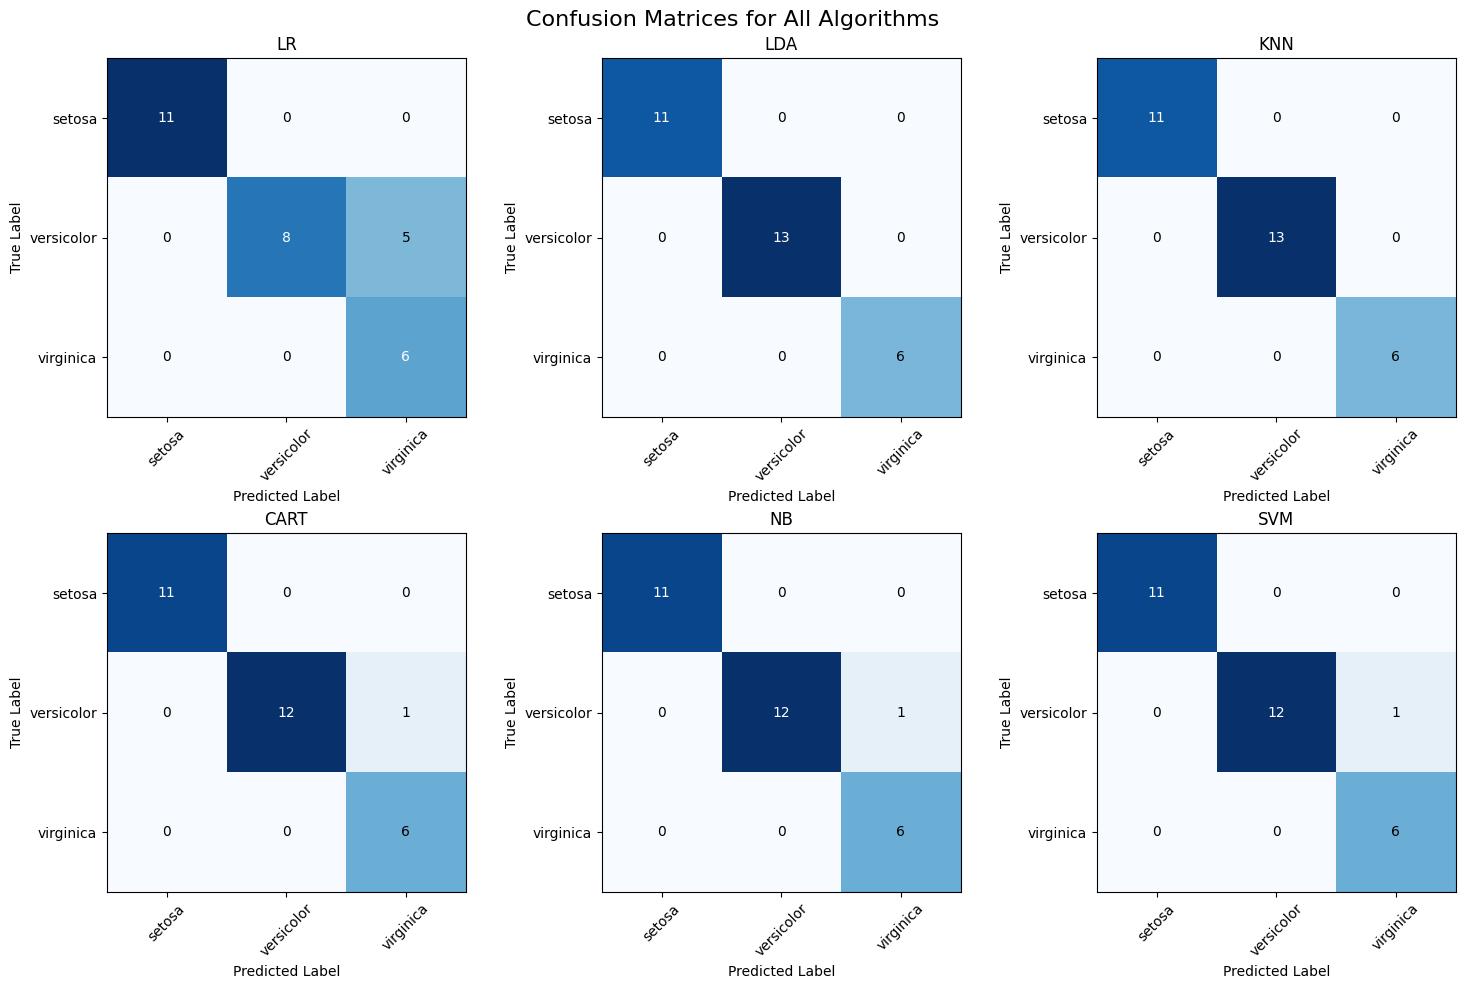

In [81]:
# Plot confusion matrices for all algorithms
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Confusion Matrices for All Algorithms', fontsize=16)

algorithms = list(models.keys())
for i, name in enumerate(algorithms):
    row = i // 3
    col = i % 3

    y_pred = predictions[name]
    cm = confusion_matrix(y_validation, y_pred)

    im = axes[row, col].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[row, col].set_title(f'{name}')

    # Add text annotations
    thresh = cm.max() / 2.
    for j in range(cm.shape[0]):
        for k in range(cm.shape[1]):
            axes[row, col].text(k, j, format(cm[j, k], 'd'),
                               ha="center", va="center",
                               color="white" if cm[j, k] > thresh else "black")

    axes[row, col].set_ylabel('True Label')
    axes[row, col].set_xlabel('Predicted Label')
    axes[row, col].set_xticks(range(len(target_names)))
    axes[row, col].set_yticks(range(len(target_names)))
    axes[row, col].set_xticklabels(target_names, rotation=45)
    axes[row, col].set_yticklabels(target_names)

plt.tight_layout()
plt.show()
